In [1]:
import numpy as np
from scipy.special import psi
from scipy.special import loggamma
from scipy.special import gamma as gammaf
import scipy as sp
import networkx as nx
import os
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
np.random.seed(123)

In [4]:
edges=np.genfromtxt("./edges.txt",delimiter='\t',dtype=int)

In [5]:
G=nx.Graph()
G.add_edges_from(edges)
conncomp = sorted(nx.connected_components(G), key=len, reverse=True)
G = nx.induced_subgraph(G, conncomp[0])
A = nx.adjacency_matrix(G)

In [6]:
N=500
K=100
epsilon=0.1

In [12]:
max_iter = 50
rho=100**(-1)

In [13]:
'''initialization'''
alpha=np.ones(K)

eta=np.ones(2)*[2,1]

lamb=np.ones((K,2))*[2,1]

gamma_ab=np.random.uniform(low=1,high=2,size=(N,K)) #np.ones((N,K))*(2*N/K)#np.random.uniform(low=1,high=5,size=(N,K))
gamma_ba=np.random.uniform(low=1,high=2,size=(N,K)) #np.ones((N,K))*(2*N/K)#np.random.uniform(low=1,high=5,size=(N,K))

#phi_ab= np.ones((N,K))*(1/K)
#phi_ba= np.zeros((N,K))*(1/K)

phi_ab= np.ones((N,N,K))*(1/K)
phi_ba= np.ones((N,N,K))*(1/K)
for p in range(N):
    phi_ab[p,:,:]=np.reshape(np.ravel(np.random.dirichlet(alpha,size=N)),(N,K),order='C')
for q in range(N):
    phi_ba[q,:,:]=np.reshape(np.ravel(np.random.dirichlet(alpha,size=N)),(N,K),order='C')


In [14]:
#G=nx.karate_club_graph()
#A = nx.adjacency_matrix(G)
#a2=A.todense()
#Y=a2
#N=Y.shape[0]
#K=2
#epsilon=0.1

In [14]:
converge=False
iteration=0
max_iter=250
L=np.zeros(max_iter+1)

while not converge:
    iteration = iteration + 1
    rho=(100+iteration)**(-1)
    
    g1 =nx.induced_subgraph(G,nbunch=list(range(0,N+1)))
    #conncomp = sorted(nx.connected_components(g1), key=len, reverse=True)
    #g2 = nx.induced_subgraph(g1, conncomp[0])
    
    a1 = nx.adjacency_matrix(g1)
    a2=a1.todense()
    Y=a2
    
    for p in range(N):
        for q in range(N):
            new_phi = np.zeros(K)
            for g in range(K):
                if Y[p,q]==0:
                    new_phi[g] = np.exp(psi(gamma_ab[p,g])-psi(np.sum(gamma_ab[p,:])) + phi_ba[q,p,g]*(psi(lamb[g,1])-psi(np.sum(lamb[g,:]))) + (1-phi_ba[q,p,g])*np.log(1-epsilon))
                else:
                    new_phi[g] = np.exp(psi(gamma_ab[p,g])-psi(np.sum(gamma_ab[p,:])) + phi_ba[q,p,g]*(psi(lamb[g,0])-psi(np.sum(lamb[g,:]))) + (1-phi_ba[q,p,g])*np.log(epsilon))
            phi_ab[p,q,:] = new_phi/np.sum(new_phi)

    for p in range(N):
        for q in range(N):
            new_phi = np.zeros(K)
            for g in range(K):
                if Y[p,q]==0:
                    new_phi[g] = np.exp(psi(gamma_ba[q,g])-psi(np.sum(gamma_ba[q,:])) + phi_ab[p,q,g]*(psi(lamb[g,1])-psi(np.sum(lamb[g,:]))) + (1-phi_ab[p,q,g])*np.log(1-epsilon))
                else:
                    new_phi[g] = np.exp(psi(gamma_ba[q,g])-psi(np.sum(gamma_ba[q,:])) + phi_ab[p,q,g]*(psi(lamb[g,0])-psi(np.sum(lamb[g,:]))) + (1-phi_ab[p,q,g])*np.log(epsilon))
            phi_ba[q,p,:] = new_phi/np.sum(new_phi)
        
    '''Update gamma''' 
    for p in range(N):
        for k in range(K):
            gamma_ab[p,k]=(1-rho)*gamma_ab[p,k]+rho*(alpha[k]+np.sum(phi_ab[p,:,k]))# +phi_ba[:,p,k]))
            gamma_ba[p,k]=(1-rho)*gamma_ba[p,k]+rho*(alpha[k]+np.sum(phi_ba[p,:,k]))#+phi_ab[:,p,k]))

            
    '''Update lambda'''
    for k in range(K):
        s0=0
        s1=1
        for p in range(N):
            for q in range(N):
                s0=s0+phi_ab[p,q,k]*phi_ba[q,p,k]*Y[p,q]
                s1=s1+phi_ab[p,q,k]*phi_ba[q,p,k]*(1-Y[p,q])
        lamb[k,0]= (1-rho)* lamb[k,0] + rho* (eta[0]+ s0 )
        lamb[k,1]= (1-rho)* lamb[k,1] + rho* (eta[1]+ s1 )
    
    l1=0
    l2=0
    for k in range(k):
        #l1=l1+np.log(gammaf(eta[0])*gammaf(eta[1])/gammaf(eta[0]+eta[1]))
        #l2=l2+np.log(gammaf(lamb[k,0])*gammaf(lamb[k,1])/gammaf(lamb[k,0]+lamb[k,1]))
        l1=l1+loggamma(eta[0])+loggamma(eta[1])-loggamma(eta[0]+eta[1])
        l2=l2+loggamma(lamb[k,0])+loggamma(lamb[k,1])-loggamma(lamb[k,0]+lamb[k,1])
        for j in range(2):
            l1=l1+(eta[j]-1)*(psi(lamb[k,j])-psi(np.sum(lamb[k,:])))
            l2=l2+(lamb[k,j]-1)*(psi(lamb[k,j])-psi(np.sum(lamb[k,:])))
    
    l3=0
    l4=0
    for p in range(N):
        l3=l3+loggamma(np.sum(alpha))
        l4=l4+loggamma(np.sum(gamma_ab[p,:]))
        for k in range(K):
            l3=l3-loggamma(alpha[k])+(alpha[k]-1)*(psi(gamma_ab[p,k])-psi(np.sum(gamma_ab[p,:])))
            l4=l4-loggamma(gamma_ab[p,k])+(gamma_ab[p,k]-1)*(psi(gamma_ab[p,k])-psi(np.sum(gamma_ab[p,:])))
        
    
    l5=0
    l6=0
    l7=0
    for p in range(N):
        for q in range(N):
            for k in range(K):
                l5=l5+phi_ab[p,q,k]*(psi(gamma_ab[p,k])-psi(np.sum(gamma_ab[p,:])))+phi_ba[q,p,k]*(psi(gamma_ba[q,k])-psi(np.sum(gamma_ba[q,:])))
                l6=l6+phi_ab[p,q,k]*np.log(phi_ab[p,q,k])+ phi_ba[q,p,k]*np.log(phi_ba[q,p,k])
                beta=np.random.beta(lamb[k,0],lamb[k,1])
                l7=l7+phi_ab[p,q,k]*(phi_ba[q,p,k]*(Y[p,q]*np.log(beta)+(1-Y[p,q])*np.log(1-beta))+(1-phi_ba[q,p,k])*(Y[p,q]*np.log(epsilon)+(1-Y[p,q])*np.log(1-epsilon)))
    

    L[iteration]=l1-l2+l3-l4+l5-l6+l7
    
    if iteration >1:
        if abs(L[iteration] - L[iteration-1]) < 1e-1:
            converge=True
    
    if np.isinf(L[iteration])==True:
        converge=True
    
    if L[iteration] < L[iteration-1]:
        converge=True
    
    if iteration >= max_iter:
        converge=True
    
    print((l1-l2,l3-l4,l5-l6,l7,L[iteration]))

(65.97910041675512, -3632.234652089799, -176182.4227834018, -33292.24457859363, -213040.92291366844)
(116.57282007268645, -3921.5553834397288, -170919.85147146834, -32854.786586385824, -207579.6206212213)
(157.42282807598303, -4209.837413397239, -166072.52771587484, -32539.685275540825, -202664.62757673688)
(191.5471849178323, -4496.069113403035, -161575.97330160253, -32299.096449623383, -198179.59167971092)
(220.76144363829255, -4779.467290066386, -157393.5146660395, -32109.27765355752, -194061.49816602495)
(246.24083616947277, -5059.430036794482, -153493.43508638302, -31954.475692228596, -190261.09997923643)
(268.78860814627785, -5335.4997220593505, -149848.1503928546, -31826.64751459461, -186741.50902136217)
(288.9773038040847, -5607.333850624185, -146433.55240842747, -31719.224184914354, -183471.13314016195)
(307.22891087794005, -5874.682018453925, -143228.47666155826, -31627.61475842368, -180423.54452755782)
(323.8630654856088, -6137.36760098525, -140214.26609438425, -31547.922310

(660.6411612018301, -16284.573499364604, -73357.6631535883, -30640.25407115365, -119621.84956290474)
(662.328864635434, -16357.051751283463, -73066.12257350236, -30638.146912267825, -119398.99237241822)
(663.9906749413263, -16428.5536187173, -72780.01563169807, -30636.033104031016, -119180.61167950522)
(665.6272301518852, -16499.0986006234, -72499.19188996311, -30634.05662227699, -118966.71988271174)
(667.2391461101197, -16568.705685767753, -72223.50642058486, -30631.95868296547, -118756.93164320801)
(668.8270174758227, -16637.393368960882, -71952.8195439144, -30630.19564534634, -118551.58154074571)
(670.3914186754062, -16705.179666665557, -71686.99658891372, -30628.22532450277, -118350.01016140645)
(671.9329047991536, -16772.082132070384, -71425.90768819628, -30626.399727573917, -118152.45664304151)
(673.4520124493522, -16838.11786958677, -71169.42754601967, -30624.653016281205, -117958.74641943804)
(674.949260542497, -16903.303548840777, -70917.43525224738, -30622.829884751856, -1177

(746.075774049855, -20088.80770814125, -59884.1479798886, -30551.007869913625, -109777.88778389376)
(746.7345657090217, -20118.891025128396, -59790.64690463757, -30550.525037608993, -109713.32840166609)
(747.3874659656736, -20148.71155379282, -59698.13929526042, -30549.854149819526, -109649.31753290695)
(748.0345558798722, -20178.272716556385, -59606.60939908866, -30549.45580794137, -109586.30336770635)
(748.6759149869117, -20207.577876681695, -59516.04180386523, -30548.83185955358, -109523.77562511375)
(749.3116213340065, -20236.630339515104, -59426.42141508311, -30548.371997731723, -109462.11213099583)
(749.9417515159137, -20265.433353725908, -59337.73345397459, -30547.746109586635, -109400.97116577109)
(750.5663807094968, -20293.99011252474, -59249.96344767418, -30547.357929180907, -109340.74510867015)
(751.1855827073022, -20322.303754852997, -59163.09722080454, -30546.74525078352, -109280.96064373397)
(751.7994299501353, -20350.377366507455, -59077.12088793935, -30546.191262340937,

KeyboardInterrupt: 

In [15]:
iteration

177

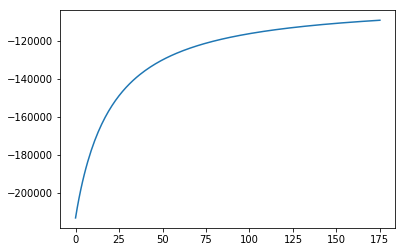

In [16]:
plt.plot(L[1:iteration])

In [19]:
phi_ab176=phi_ab
phi_ba176=phi_ba
gamma_ab176=gamma_ab
gamma_ba176=gamma_ba
lamb176=lamb

In [21]:
phi_ab176[1,1:10,:]

array([[0.00616249, 0.01238368, 0.00998457, 0.00829043, 0.00652448,
        0.01345904, 0.01331915, 0.01141416, 0.01007615, 0.00961364,
        0.00915204, 0.00853638, 0.00934077, 0.00705832, 0.00887579,
        0.00780708, 0.00809219, 0.01121973, 0.01261366, 0.00647485,
        0.00699813, 0.00934586, 0.01040285, 0.01099282, 0.01194963,
        0.0135021 , 0.00729211, 0.01165995, 0.01151308, 0.01060858,
        0.00923486, 0.01148881, 0.00776543, 0.00953433, 0.00692682,
        0.01153532, 0.0121606 , 0.01225396, 0.0075608 , 0.00844602,
        0.01233283, 0.00723457, 0.00615461, 0.00803737, 0.01088538,
        0.00648167, 0.01126312, 0.01224433, 0.00803925, 0.01035851,
        0.01345402, 0.01334873, 0.01188483, 0.00915826, 0.0116193 ,
        0.01262097, 0.01281307, 0.00708794, 0.00907937, 0.00874625,
        0.00886271, 0.00897727, 0.01037803, 0.01089563, 0.00630816,
        0.01356696, 0.01081327, 0.01125985, 0.01225511, 0.01353486,
        0.00679383, 0.00696321, 0.00944681, 0.00

In [20]:
gamma_ab176[1,1:10]

array([5.30561394, 4.37083949, 3.71033915, 3.02031935, 5.72456115,
       5.66984433, 4.92795246, 4.40674645, 4.2263985 ])

In [22]:
lamb176[1:10,:]

array([[ 2.1201656 , 17.27219055],
       [ 2.12467935, 17.68746419],
       [ 2.12252559, 17.38422758],
       [ 2.12323264, 17.14106392],
       [ 2.12174734, 16.91050978],
       [ 2.12157   , 17.3257929 ],
       [ 2.12302501, 17.47703735],
       [ 2.12669586, 17.73614571],
       [ 2.11686154, 17.6228287 ]])

In [18]:
L[176]

-108992.21050532571

In [31]:
L2 = np.zeros(250)
L2 [0:177]=L[0:177]


In [ ]:
converge=False
iteration=177
max_iter=250


while not converge:
    iteration = iteration + 1
    rho=(100+iteration)**(-1)
    
    g1 =nx.induced_subgraph(G,nbunch=list(range(0,N+1)))
    #conncomp = sorted(nx.connected_components(g1), key=len, reverse=True)
    #g2 = nx.induced_subgraph(g1, conncomp[0])
    
    a1 = nx.adjacency_matrix(g1)
    a2=a1.todense()
    Y=a2
    
    for p in range(N):
        for q in range(N):
            new_phi = np.zeros(K)
            for g in range(K):
                if Y[p,q]==0:
                    new_phi[g] = np.exp(psi(gamma_ab[p,g])-psi(np.sum(gamma_ab[p,:])) + phi_ba[q,p,g]*(psi(lamb[g,1])-psi(np.sum(lamb[g,:]))) + (1-phi_ba[q,p,g])*np.log(1-epsilon))
                else:
                    new_phi[g] = np.exp(psi(gamma_ab[p,g])-psi(np.sum(gamma_ab[p,:])) + phi_ba[q,p,g]*(psi(lamb[g,0])-psi(np.sum(lamb[g,:]))) + (1-phi_ba[q,p,g])*np.log(epsilon))
            phi_ab[p,q,:] = new_phi/np.sum(new_phi)

    for p in range(N):
        for q in range(N):
            new_phi = np.zeros(K)
            for g in range(K):
                if Y[p,q]==0:
                    new_phi[g] = np.exp(psi(gamma_ba[q,g])-psi(np.sum(gamma_ba[q,:])) + phi_ab[p,q,g]*(psi(lamb[g,1])-psi(np.sum(lamb[g,:]))) + (1-phi_ab[p,q,g])*np.log(1-epsilon))
                else:
                    new_phi[g] = np.exp(psi(gamma_ba[q,g])-psi(np.sum(gamma_ba[q,:])) + phi_ab[p,q,g]*(psi(lamb[g,0])-psi(np.sum(lamb[g,:]))) + (1-phi_ab[p,q,g])*np.log(epsilon))
            phi_ba[q,p,:] = new_phi/np.sum(new_phi)
        
    '''Update gamma''' 
    for p in range(N):
        for k in range(K):
            gamma_ab[p,k]=(1-rho)*gamma_ab[p,k]+rho*(alpha[k]+np.sum(phi_ab[p,:,k]))# +phi_ba[:,p,k]))
            gamma_ba[p,k]=(1-rho)*gamma_ba[p,k]+rho*(alpha[k]+np.sum(phi_ba[p,:,k]))#+phi_ab[:,p,k]))

            
    '''Update lambda'''
    for k in range(K):
        s0=0
        s1=1
        for p in range(N):
            for q in range(N):
                s0=s0+phi_ab[p,q,k]*phi_ba[q,p,k]*Y[p,q]
                s1=s1+phi_ab[p,q,k]*phi_ba[q,p,k]*(1-Y[p,q])
        lamb[k,0]= (1-rho)* lamb[k,0] + rho* (eta[0]+ s0 )
        lamb[k,1]= (1-rho)* lamb[k,1] + rho* (eta[1]+ s1 )
    
    l1=0
    l2=0
    for k in range(k):
        #l1=l1+np.log(gammaf(eta[0])*gammaf(eta[1])/gammaf(eta[0]+eta[1]))
        #l2=l2+np.log(gammaf(lamb[k,0])*gammaf(lamb[k,1])/gammaf(lamb[k,0]+lamb[k,1]))
        l1=l1+loggamma(eta[0])+loggamma(eta[1])-loggamma(eta[0]+eta[1])
        l2=l2+loggamma(lamb[k,0])+loggamma(lamb[k,1])-loggamma(lamb[k,0]+lamb[k,1])
        for j in range(2):
            l1=l1+(eta[j]-1)*(psi(lamb[k,j])-psi(np.sum(lamb[k,:])))
            l2=l2+(lamb[k,j]-1)*(psi(lamb[k,j])-psi(np.sum(lamb[k,:])))
    
    l3=0
    l4=0
    for p in range(N):
        l3=l3+loggamma(np.sum(alpha))
        l4=l4+loggamma(np.sum(gamma_ab[p,:]))
        for k in range(K):
            l3=l3-loggamma(alpha[k])+(alpha[k]-1)*(psi(gamma_ab[p,k])-psi(np.sum(gamma_ab[p,:])))
            l4=l4-loggamma(gamma_ab[p,k])+(gamma_ab[p,k]-1)*(psi(gamma_ab[p,k])-psi(np.sum(gamma_ab[p,:])))
        
    
    l5=0
    l6=0
    l7=0
    for p in range(N):
        for q in range(N):
            for k in range(K):
                l5=l5+phi_ab[p,q,k]*(psi(gamma_ab[p,k])-psi(np.sum(gamma_ab[p,:])))+phi_ba[q,p,k]*(psi(gamma_ba[q,k])-psi(np.sum(gamma_ba[q,:])))
                l6=l6+phi_ab[p,q,k]*np.log(phi_ab[p,q,k])+ phi_ba[q,p,k]*np.log(phi_ba[q,p,k])
                beta=np.random.beta(lamb[k,0],lamb[k,1])
                l7=l7+phi_ab[p,q,k]*(phi_ba[q,p,k]*(Y[p,q]*np.log(beta)+(1-Y[p,q])*np.log(1-beta))+(1-phi_ba[q,p,k])*(Y[p,q]*np.log(epsilon)+(1-Y[p,q])*np.log(1-epsilon)))
    

    L2[iteration]=l1-l2+l3-l4+l5-l6+l7
    
    if iteration >1:
        if abs(L2[iteration] - L2[iteration-1]) < 1e-1:
            converge=True
    
    if np.isinf(L2[iteration])==True:
        converge=True
    
    #if L2[iteration] < L2[iteration-1]:
    #    converge=True
    
    if iteration >= max_iter:
        converge=True
    
    print((l1-l2,l3-l4,l5-l6,l7,L2[iteration]))

(754.7886753489008, -20487.15260636984, -58660.414612262044, -30543.66038206488, -108936.43892534764)
(755.3697646973908, -20513.75281159114, -58579.789171041455, -30543.225520969703, -108881.39773890503)
(755.9460058159898, -20540.13475446406, -58499.95828055218, -30542.75572646854, -108826.90275566865)
(756.5174607319741, -20566.30110501891, -58420.91025747033, -30542.327890538763, -108773.021792296)
(757.0841903910364, -20592.254489895364, -58342.633643179666, -30541.966565451577, -108719.77050813567)
(757.6462546813434, -20617.997493223258, -58265.117202671245, -30541.30927548585, -108666.77771669887)
(758.2037124569611, -20643.532657500356, -58188.3499185089, -30540.942702745153, -108614.62156629754)
(758.7566215606362, -20668.862484379642, -58112.32098495914, -30540.515031769173, -108562.94187954743)
(759.3050388459624, -20693.989435533324, -58037.01980407722, -30539.97279168497, -108511.67699244962)
(759.8490201989576, -20718.91593343357, -57962.43597494671, -30539.58650410236, 